# Color transfer by optimal transport

In [1]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# super pixels
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

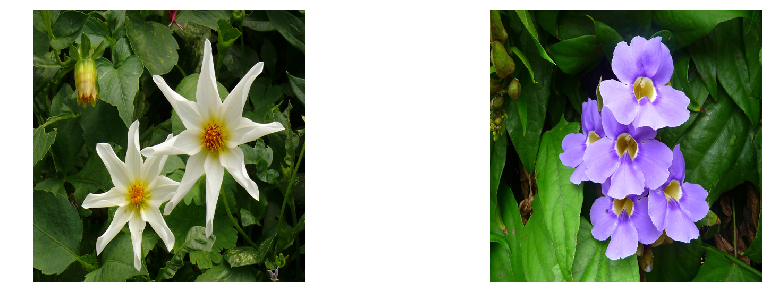

In [2]:
# image loading
flower1 = Image.open('flower_1.jpg')
flower2 = Image.open('flower_2.jpg')

# conversion to [0,1]-valued arrays
u = np.array(flower1, dtype='float') / 255
v = np.array(flower2, dtype='float') / 255

# image display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(flower1)
ax1.axis('off')

ax2.imshow(flower2)
ax2.axis('off');

In [3]:
def compute_clusters(image, num_segments=300):
    segments = slic(image, n_segments=num_segments, sigma=5)
    
    clusters = [{} for _ in range(np.unique(segments).size)]
    
    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            cluster_idx = segments[i, j]
        
            if clusters[cluster_idx] == {}:
                clusters[cluster_idx]['spatial_mean'] = np.array([i, j], dtype='float')
                clusters[cluster_idx]['color_mean'] = image[i, j]
                clusters[cluster_idx]['num_pixels'] = 1
            else:
                clusters[cluster_idx]['spatial_mean'] += np.array([i, j])
                clusters[cluster_idx]['color_mean'] += image[i, j]
                clusters[cluster_idx]['num_pixels'] += 1
            
    for cluster_idx in range(len(clusters)):
        clusters[cluster_idx]['spatial_mean'] *= 1.0 / clusters[cluster_idx]['num_pixels']
        clusters[cluster_idx]['color_mean'] *= 1.0 / clusters[cluster_idx]['num_pixels']
        
    return clusters, segments

In [4]:
# clusters computation
u_clusters, u_segments = compute_clusters(u)
v_clusters, v_segments = compute_clusters(v)

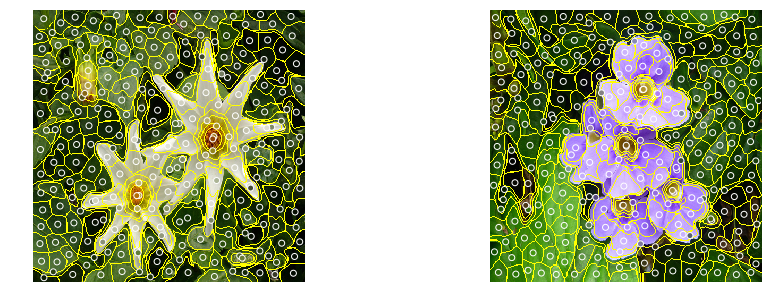

In [5]:
# clusters display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.imshow(mark_boundaries(u, u_segments))
ax1.scatter([u_clusters[cluster_idx]['spatial_mean'][1] for cluster_idx in range(len(u_clusters))],
            [u_clusters[cluster_idx]['spatial_mean'][0] for cluster_idx in range(len(u_clusters))],
            facecolor=[u_clusters[cluster_idx]['color_mean'] for cluster_idx in range(len(u_clusters))],
            edgecolor='white')
ax1.axis('off')

ax2.imshow(mark_boundaries(v, v_segments))
ax2.scatter([v_clusters[cluster_idx]['spatial_mean'][1] for cluster_idx in range(len(v_clusters))],
            [v_clusters[cluster_idx]['spatial_mean'][0] for cluster_idx in range(len(v_clusters))],
            facecolor=[v_clusters[cluster_idx]['color_mean'] for cluster_idx in range(len(v_clusters))],
            edgecolor='white')

ax2.axis("off");

In [6]:
def compute_histogram(image, clusters):
    num_pixels = image.size
    hist = []
    features = []
    
    for cluster in clusters:
        hist.append(cluster['num_pixels'] / num_pixels)
        features.append(np.hstack([cluster['spatial_mean'], cluster['color_mean']]))
        
    return np.array(hist), np.array(features)

In [7]:
def simplex_projection(x):
    n = x.size
    x_sorted = np.sort(x)
    
    i = n - 1
    t_i = (np.sum(x_sorted[i+1:n]) - 1) / (n - i)
    
    while t_i < x_sorted[i] and i > 0:
        i = i - 1
        t_i = (np.sum(x_sorted[i+1:n]) - 1) / (n - i)
    
    if t_i >= x_sorted[i]:
        t_hat = t_i
    else:
        t_hat = (np.sum(x) - 1) / n
            
    return np.maximum(x - t_hat, 0)

In [8]:
def simplex_projection(x):
    n = x.size
    x_sorted = np.sort(x)
        
    i = n - 2
    t_i = (np.sum(x_sorted[i+1:]) - 1) / (n - (i + 1))
        
    while t_i < x_sorted[i] and i >= 0:
        i = i - 1
        t_i = (np.sum(x_sorted[i+1:n]) - 1) / (n - (i + 1))
        
    if i < 0:
        t_hat = (np.sum(x) - 1) / n
    else:
        t_hat = t_i
                
    projection = np.maximum(x - t_hat, 0)
    assert(np.allclose(projection.dot(np.ones_like(projection)), 1))
    
    return projection

In [9]:
def transport_matrix_projection(P, hist):
    projection = np.copy(P)
    
    for i in range(P.shape[0]):
        projection[i] = hist[i] * simplex_projection(P[i])
        
    return projection

In [10]:
def color_transfer(original_image, target_image, num_iter=10, gamma=0.1):
    original_clusters, _ = compute_clusters(original_image)
    target_clusters, _ = compute_clusters(target_image)
    
    original_hist, original_features = compute_histogram(original_image, original_clusters)
    target_hist, target_features = compute_histogram(target_image, target_clusters)
    
    cost_matrix = np.array([[np.linalg.norm(original_features[i] - target_features[j]) ** 2 
                             for j in range(target_features.shape[0])] for i in range(original_features.shape[0])])
    
    P = transport_matrix_projection(np.random.rand(original_features.shape[0], target_features.shape[0]),
                                    original_hist)
    
    for _ in range(num_iter):
        P = transport_matrix_projection(P - gamma * cost_matrix, original_hist)

    assert(np.allclose(P.dot(np.ones(P.shape[1])), original_hist))    
    
    return P

In [11]:
transport_matrix = color_transfer(u, v)

NameError: name 'pojection' is not defined